In [37]:
from unicodedata import bidirectional

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as dist
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sympy.stats.rv import probability
from torch.nn.functional import adaptive_avg_pool1d
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [44]:
# Verify that GPU is connected and available
print(torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.cuda.get_device_name(0))

2.5.1
NVIDIA GeForce RTX 4060 Laptop GPU


In [84]:
def generate_data(sequence_length: int, T: int, has_breakpoint: bool) -> torch.Tensor:
    '''
    Generated a sequence of 10-dim vectors of length sequence_length.

    :param sequence_length: Specified length of the sequence to be generated
    :param T: The breakpoint after which the sequence starts to behave differently
    :param has_breakpoint: Specifies whether the breakpoint is present in the sequence

    :return:
    '''

    # Setup normal dist
    normal_dist = dist.Normal(0, 1)
    # Make a normal set of vectors for the initial sequence
    normal_sequence = normal_dist.sample((sequence_length if not has_breakpoint else T, 10))

    if not has_breakpoint:
        return normal_sequence

    # Define the number of vectors after the breakpoint
    anomaly_length = sequence_length - T

    # A list to hold the post-T vectors
    sequence_list = []

    # Randomly select and generate indices and their means
    random_indices = np.random.choice(10, size=5, replace=False)
    random_means = np.random.uniform(-1, 1, size=5)

    for _ in range(anomaly_length):

        # Create a placeholder sequence
        random_sequence = normal_dist.sample((10,))

        # Override 5 default values
        for index, mean in zip(random_indices, random_means):
            random_sequence[index] = dist.Normal(mean, 1).sample()

        # Add the new vector to the list
        sequence_list.append(random_sequence)

    # Combine the post_T vectors into a Tensor of size (T-1, 10)
    post_T_sequence = torch.stack(sequence_list, dim=0)

    # Combines all vectors into a Tensor of size (T, 10)
    complete_sequence = torch.cat([normal_sequence, post_T_sequence], dim=0)

    return complete_sequence

class DataWrapper(data.Dataset):

    def __init__(self, zip):
        self.data = list(zip)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

def generate_data_tensors(num_of_sequences: int = 100, custom_sequence_range: range = range(1,101), mode: bool = False) -> DataWrapper:
    '''
    Generates the dataset for problem 1

    :param num_of_sequences: Number of sequences to be generated
    :param custom_sequence_range: Length of the sequence to be generated
    :param mode: Specifies which data to generate (False for train, True for test)


    :return:
    '''

    # Initialize list of records and labels
    list_of_x = []
    list_of_y = []

    # Declare the number of sequences to be generated for each sequence length
    NUM_OF_SEQUENCES = int(num_of_sequences if not mode else num_of_sequences / 3)

    for i in custom_sequence_range:

        # Generate sequences with no breakpoint
        for _ in range(NUM_OF_SEQUENCES):
            new_sequence = generate_data(i, 0 , False)

            list_of_x.append(new_sequence)
            list_of_y.append(torch.tensor(0.0, dtype=torch.float64))

        # Generate sequences with a breakpoint
        for _ in range(NUM_OF_SEQUENCES):
            new_sequence = generate_data(i, np.random.randint(0, i), True)

            list_of_x.append(new_sequence)
            list_of_y.append(torch.tensor(1.0, dtype=torch.float64))

    list_of_y = torch.stack(list_of_y, dim=0)

    return DataWrapper(zip(list_of_x, list_of_y))

def generate_padded_data(batch):

    # 1. Separate the data and labels
    data_tensors = [item[0] for item in batch]
    label_tensors = [item[1] for item in batch]

    # 2. Get original lengths
    lengths = torch.tensor([t.shape[0] for t in data_tensors], dtype=torch.int64)

    # 3. Sort lengths in DESCENDING order and get the permutation indices
    # This step is critical for pack_padded_sequence stability.
    lengths_sorted, sorted_idx = lengths.sort(descending=True)

    # 4. Sort the data and labels lists using the obtained indices
    data_tensors_sorted = [data_tensors[i] for i in sorted_idx]
    label_tensors_sorted = [label_tensors[i] for i in sorted_idx]

    # 5. Pad the sorted sequences
    padded_sequences = pad_sequence(data_tensors_sorted, batch_first=True, padding_value=0.0)

    # 6. Stack the sorted labels
    labels = torch.stack(label_tensors_sorted)

    # Return the three components, now correctly sorted
    return padded_sequences, lengths_sorted, labels


In [50]:
class AnomalyDetectorLSTM(nn.Module):
    '''

    LSTM NN for Question 1

    '''

    def __init__(self,
                 input_size=10,
                 hidden_size=10,
                 LSTM_layers=1,
                 LSTM_dropout=0,
                 linear_dropout=0,
                 bidirectional=False
                 ):
        super().__init__()

        # Define the LSTM for the NN
        self.LSTM = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=LSTM_layers,
            dropout=LSTM_dropout,
            bidirectional=bidirectional,
            batch_first=True
        )

        self.layer_1_size = 100
        self.layer_2_size = 50
        self.layer_3_size = 20
        self.output_layer_size = 1

        self.classifier = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=self.layer_1_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.layer_1_size, out_features=self.layer_2_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.layer_2_size, out_features=self.layer_3_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.layer_3_size, out_features=self.output_layer_size)
        )

    def forward(self, x, lengths):

        # Pack the padded data so that the LSTM can handle variable length sequences
        packed_input = pack_padded_sequence(
            x,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        # Grab the final outputs from the LSTM
        output, (h_n, c_n) = self.LSTM(packed_input)

        # Grab the summary of the sequences
        final_hidden_state = h_n[-1]

        # Compute the final label
        logits = self.classifier(final_hidden_state)

        logits = logits.squeeze(1)

        return logits




In [87]:
# Model Hyperparameter setup
m_hidden_size=10
m_LSTM_layers=1
m_LSTM_dropout=0
m_linear_dropout=0
is_bidirectional = False

# Training Loop Hyperparameter setup
learning_rate = 1e-3
m_batch_size = 32
epochs = 10

# Data Requested
sequences_wanted = 200

m1_epoch_over_training_loss = []
m1_epoch_over_testing_loss = []

In [52]:
print('||| Generating model training data |||')

# Generate the model data
train_dataloader = DataLoader(
    generate_data_tensors(num_of_sequences=sequences_wanted),
    batch_size=m_batch_size,
    shuffle=True,
    collate_fn=generate_padded_data
)

print('||| Model data generated |||')

print('||| Generating model testing data |||')

# Generate the model data
test_dataloader = DataLoader(
    generate_data_tensors(num_of_sequences=sequences_wanted, mode=True),
    batch_size=m_batch_size,
    shuffle=False,
    collate_fn=generate_padded_data
)

print('||| Model data generated |||\n')

||| Generating model training data |||
||| Model data generated |||
||| Generating model testing data |||
||| Model data generated |||



In [88]:
# Setup model, optimizer, and loss function
model = AnomalyDetectorLSTM(
    hidden_size=m_hidden_size,
    LSTM_layers=m_LSTM_layers,
    LSTM_dropout=m_LSTM_dropout,
    linear_dropout=m_linear_dropout,
    bidirectional=is_bidirectional
).to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print('########## Starting Training Loop for Anomaly Detection LSTM ##########\n')

for epoch in range(epochs):

    model.train()

    total_training_loss = 0
    total_testing_loss = 0

    avg_training_loss = 0
    avg_testing_loss = 0

    print(f'~~~~~ Epoch {epoch + 1}/{epochs} ~~~~~')

    for X_batch, length_batch, y_batch in tqdm(train_dataloader, desc='Training', unit=' batches'):
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.float().to(device)

        logits = model(X_batch, length_batch)

        loss = loss_function(logits, y_batch)

        with torch.no_grad():
            total_training_loss += loss.item()

        loss.backward()
        optimizer.step()

    model.eval()

    # Calc testing loss
    with torch.no_grad():
        for X_t_batch, length_t_batch, y_t_batch in tqdm(test_dataloader, desc='Testing', unit=' batches'):
                X_t_batch = X_t_batch.to(device)
                y_t_batch = y_t_batch.float().to(device)

                t_logits = model(X_t_batch, length_t_batch)

                total_testing_loss += loss_function(t_logits, y_t_batch).item()

        avg_training_loss = total_training_loss / len(train_dataloader)
        avg_testing_loss = total_testing_loss / len(test_dataloader)

    m1_epoch_over_training_loss.append({
        'epoch': epoch + 1,
        'training_loss': avg_training_loss,
    })

    m1_epoch_over_testing_loss.append({
        'epoch': epoch + 1,
        'testing_loss': avg_testing_loss,
    })

    print(f'     -> Training Loss: {avg_training_loss:.4f}\n')
    print(f'     -> Testing Loss: {avg_testing_loss:.4f}\n')

########## Starting Training Loop for Anomaly Detection LSTM ##########

~~~~~ Epoch 1/10 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 1051.00 batches/s]


     -> Training Loss: 0.5767

     -> Testing Loss: 0.5056

~~~~~ Epoch 2/10 ~~~~~


Training:  64%|██████▍   | 805/1250 [00:03<00:01, 266.98 batches/s]


KeyboardInterrupt: 

In [61]:
def generate_plot_data(num_of_sequences_requested: int = 100) -> DataWrapper:

    list_of_x = []
    list_of_y = []
    list_of_r = []

    for _ in range(num_of_sequences_requested):
        # The range of sequence lengths
        for i in range(20, 80, 2):

            # Get the sequence
            seq = generate_data(10 + i, i, True)

            # Get data from [-10, 10]
            for r in range(-10, 11, 1):
                list_of_x.append(
                    seq[ : i + r]
                )

                # Generate the label with the sequence slices
                list_of_y.append(torch.tensor(1.0, dtype=torch.float64))

                # Store the distance from the breakpoint
                list_of_r.append(r)


    # Combine labels
    list_of_y = torch.stack(list_of_y)

    return DataWrapper(zip(list_of_x, list_of_y, list_of_r))


def generate_padded_plot_data(batch):

    data_tensors = [item[0] for item in batch]
    label_tensors = [item[1] for item in batch]
    r_values = [item[2] for item in batch]

    data_lengths = torch.tensor([data.shape[0] for data in data_tensors], dtype=torch.int64)
    padded_sequence = pad_sequence(data_tensors, batch_first=True, padding_value=0)

    labels = torch.stack(label_tensors)

    r_values = torch.tensor(r_values, dtype=torch.int64)

    return padded_sequence, data_lengths, labels, r_values



In [63]:
model.eval()

plot_range = range(-10, 11)

probability_by_r_dict = {r: [] for r in plot_range}

plot_data_dataloader = DataLoader(
    generate_plot_data(),
    batch_size=m_batch_size,
    shuffle=False,
    collate_fn=generate_padded_plot_data
)

with torch.no_grad():
    for x_batch, length_batch, y_batch, r_batch in tqdm(plot_data_dataloader, desc='Evaluating', unit=' batches'):

        x_batch = x_batch.to(device)
        y_batch = y_batch.float().to(device)

        logits = model(x_batch, length_batch)

        probabilities = torch.sigmoid(logits).cpu().numpy()

        r_indices = r_batch.cpu().numpy()

        for probability, r_value in zip(probabilities, r_indices):
            probability_by_r_dict[r_value].append(probability)

x_axis = sorted(probability_by_r_dict.keys())
y_axis = [
    np.mean(probability_by_r_dict[r]) for r in plot_range
]


Evaluating: 100%|██████████| 1969/1969 [00:02<00:00, 971.63 batches/s]


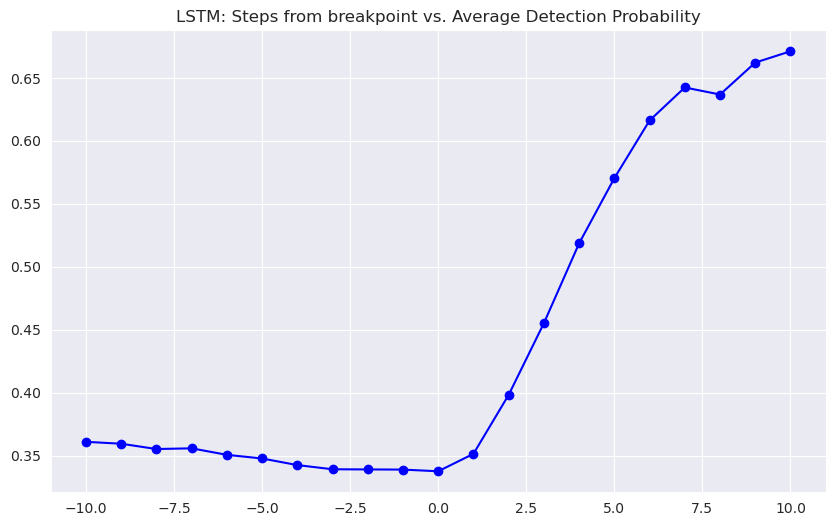

In [81]:
plt.figure(figsize=(10,6))

plt.plot(x_axis, y_axis, marker='o', linestyle='-', color='blue', label='Average Detection Probability')

plt.title('LSTM: Steps from breakpoint vs. Average Detection Probability')

plt.show()

In [76]:
class AnomalyDetectorCNN(nn.Module):

    def __init__(self, CNN_dropout=0 ,linear_dropout=0):
        super().__init__()

        self.cnn_layer_1_size = 32
        self.cnn_layer_2_size = 64

        self.cnn_dropout = CNN_dropout

        self.CNN = nn.Sequential(
            nn.Conv1d(in_channels=10, out_channels=self.cnn_layer_1_size, kernel_size=5, padding=2),
            nn.ReLU(),

            nn.Conv1d(in_channels=32, out_channels=self.cnn_layer_2_size, kernel_size=5, padding=2),
            nn.ReLU(),
        )

        self.linear_layer_1_size = 512
        self.linear_layer_2_size = 256
        self.linear_layer_3_size = 128
        self.linear_layer_4_size = 64
        self.final_output_layer_size = 1


        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.cnn_layer_2_size, out_features=self.linear_layer_1_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.linear_layer_1_size, out_features=self.linear_layer_2_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.linear_layer_2_size, out_features=self.linear_layer_3_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.linear_layer_3_size, out_features=self.linear_layer_4_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.linear_layer_4_size, out_features=self.final_output_layer_size)
        )

    def forward(self, x):

        x = x.transpose(1, 2)

        x = self.CNN(x)

        x = F.adaptive_avg_pool1d(x, 1)

        x = x.squeeze(2)

        logits = self.classifier(x).squeeze(1)

        return logits

In [89]:
# Training Loop Hyperparameter setup
m2_learning_rate = 1e-3
m2_epochs = 10

m2_epoch_over_training_loss = []
m2_epoch_over_testing_loss = []

In [79]:
model_2 = AnomalyDetectorCNN().to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_2.parameters(), lr=m2_learning_rate)

print('########## Starting Training Loop for Anomaly Detection CNN ##########\n')

for epoch in range(m2_epochs):

    model_2.train()

    total_training_loss = 0
    total_testing_loss = 0

    avg_training_loss = 0
    avg_testing_loss = 0

    print(f'~~~~~ Epoch {epoch + 1}/{m2_epochs} ~~~~~')

    for X_batch, length_batch, y_batch in tqdm(train_dataloader, desc='Training', unit=' batches'):
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.float().to(device)

        logits = model_2(X_batch)

        loss = loss_function(logits, y_batch)

        with torch.no_grad():
            total_training_loss += loss.item()

        loss.backward()
        optimizer.step()

    model_2.eval()

    # Calc testing loss
    with torch.no_grad():
        for X_t_batch, length_t_batch, y_t_batch in tqdm(test_dataloader, desc='Testing', unit=' batches'):
                X_t_batch = X_t_batch.to(device)
                y_t_batch = y_t_batch.float().to(device)

                t_logits = model_2(X_t_batch)

                total_testing_loss += loss_function(t_logits, y_t_batch).item()

        avg_training_loss = total_training_loss / len(train_dataloader)
        avg_testing_loss = total_testing_loss / len(test_dataloader)

    m2_epoch_over_training_loss.append({
        'epoch': epoch + 1,
        'training_loss': avg_training_loss,
    })

    m2_epoch_over_testing_loss.append({
        'epoch': epoch + 1,
        'testing_loss': avg_testing_loss,
    })

    print(f'     -> Training Loss: {avg_training_loss:.4f}\n')
    print(f'     -> Testing Loss: {avg_testing_loss:.4f}\n')

########## Starting Training Loop for Anomaly Detection CNN ##########

~~~~~ Epoch 1/10 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 1148.10 batches/s]


     -> Training Loss: 0.5710

     -> Testing Loss: 0.6718

~~~~~ Epoch 2/10 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 1786.66 batches/s]


     -> Training Loss: 0.4421

     -> Testing Loss: 1.4885

~~~~~ Epoch 3/10 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 1731.94 batches/s]


     -> Training Loss: 0.4116

     -> Testing Loss: 2.2201

~~~~~ Epoch 4/10 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 1744.05 batches/s]


     -> Training Loss: 0.4004

     -> Testing Loss: 1.7247

~~~~~ Epoch 5/10 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 1666.04 batches/s]


     -> Training Loss: 0.3918

     -> Testing Loss: 1.7411

~~~~~ Epoch 6/10 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 1708.13 batches/s]


     -> Training Loss: 0.3839

     -> Testing Loss: 2.6225

~~~~~ Epoch 7/10 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 1760.53 batches/s]


     -> Training Loss: 0.3802

     -> Testing Loss: 1.9199

~~~~~ Epoch 8/10 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 1720.21 batches/s]


     -> Training Loss: 0.3748

     -> Testing Loss: 2.4792

~~~~~ Epoch 9/10 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 1655.81 batches/s]


     -> Training Loss: 0.3684

     -> Testing Loss: 2.7481

~~~~~ Epoch 10/10 ~~~~~


Training:  82%|████████▏ | 1024/1250 [00:04<00:00, 232.81 batches/s]


KeyboardInterrupt: 

In [80]:
model_2.eval()

plot_range = range(-10, 11)

probability_by_r_dict = {r: [] for r in plot_range}

plot_data_dataloader = DataLoader(
    generate_plot_data(),
    batch_size=m_batch_size,
    shuffle=False,
    collate_fn=generate_padded_plot_data
)

with torch.no_grad():
    for x_batch, length_batch, y_batch, r_batch in tqdm(plot_data_dataloader, desc='Evaluating', unit=' batches'):

        x_batch = x_batch.to(device)
        y_batch = y_batch.float().to(device)

        logits = model_2(x_batch)

        probabilities = torch.sigmoid(logits).cpu().numpy()

        r_indices = r_batch.cpu().numpy()

        for probability, r_value in zip(probabilities, r_indices):
            probability_by_r_dict[r_value].append(probability)

x_axis = sorted(probability_by_r_dict.keys())
y_axis = [
    np.mean(probability_by_r_dict[r]) for r in plot_range
]


Evaluating: 100%|██████████| 1969/1969 [00:00<00:00, 1988.87 batches/s]


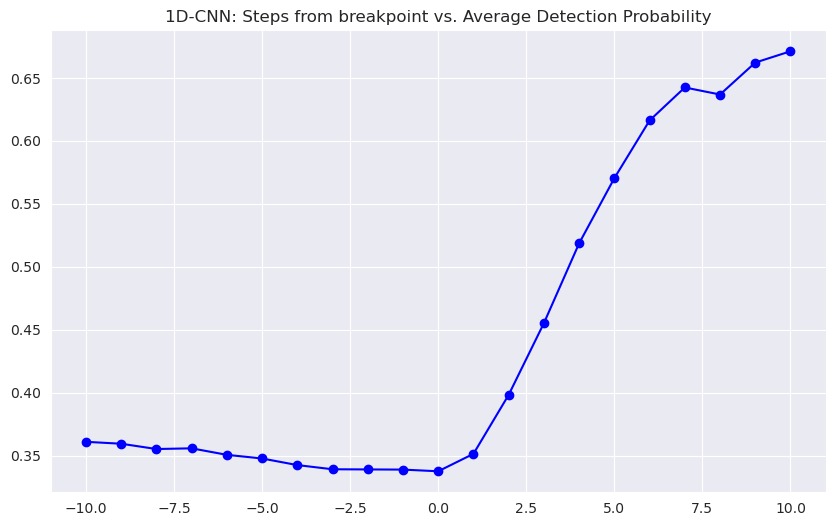

In [83]:
plt.figure(figsize=(10,6))

plt.plot(x_axis, y_axis, marker='o', linestyle='-', color='blue', label='Average Detection Probability')

plt.title('1D-CNN: Steps from breakpoint vs. Average Detection Probability')

plt.show()

In [86]:
example_dataloader = DataLoader(
    generate_data_tensors(custom_sequence_range=range(100, 201)),
    batch_size=m_batch_size,
    shuffle=True,
    collate_fn=generate_padded_data
)